In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import tensorflow as tf
import keras.layers as layers
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from utils import plot_history
import re
import string
import numpy as np
import pandas as pd

2022-12-15 21:09:36.409173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# experiment name
name = 'both_generated_using_correct_names_40k_better_repeatedfunction'

# Dataset

In [4]:
df = pd.read_csv(f"data/{name}.csv")
print(df.shape)
df.sample(10)

(40000, 2)


,Name,class
26649,شهددى ععهه ي,0.0
16458,ارينى الموجى ملازم,1.0
35607,ىابردل نايد ججنن,0.0
29072,اثارت ذاكرته تعقيدات,0.0
25829,داالحييدد جلل يانن,0.0
16320,ثروت بسخرون العبسى,1.0
6268,زيان لؤى حسونه,1.0
39357,عبدالراضى الاسناوى نسخ,0.0
3735,الحجاج وجيهه الشفاء,1.0
11638,الطاهرى عبيده السدانى,1.0


In [5]:
# max number of words per name
df['Name'].str.split().str.len().max()

3

In [6]:
df.head(5)

,Name,class
0,حمايه تيسير لاوند,1.0
1,سعداحمد ابراهبم برى,1.0
2,مكة ولاء كريمه,1.0
3,زايد ثراء سحاق,1.0
4,الاسمر الشندى العوضى,1.0


In [7]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Name,class
0,سكارنو لولى ابوشبانه,1.0
1,شدو ليزا ابوحلاوه,1.0
2,ختم بالسياسة حسنا،,0.0
3,سيدهم فريد العنين,1.0
4,ريمان زينات الصفا,1.0


## Document Preprocessing

In [8]:
# adding start and end tokens
names = ['<SOS> ' + x + ' <EOS>' for x in df['Name'].tolist()]
corpus = " ".join(names)
labels = df['class'].tolist()
corpus[:1000]

'<SOS> سكارنو لولى ابوشبانه <EOS> <SOS> شدو ليزا ابوحلاوه <EOS> <SOS> ختم بالسياسة حسنا، <EOS> <SOS> سيدهم فريد العنين <EOS> <SOS> ريمان زينات الصفا <EOS> <SOS> شيماء مرام الجرى <EOS> <SOS> العبدالشناوى شدوى عزوز <EOS> <SOS> للصفحة سلامه ابكتني <EOS> <SOS> نسميه لبىشاراو ااءسم <EOS> <SOS> نظرها جنسيا بىدو <EOS> <SOS> تيولب ماريه فنجرى <EOS> <SOS> الصين المنباوى الكتب، <EOS> <SOS> رجائى الفروجى الموافى <EOS> <SOS> رودده ررااججح نبى <EOS> <SOS> ضياءالدين عبادة يعقوب <EOS> <SOS> نوسة ابرهيم شدوى <EOS> <SOS> الرميصاء مسعد عبداالمجيد <EOS> <SOS> رببيع لس ددالححيمم <EOS> <SOS> جلشان عبوده عمرو <EOS> <SOS> الهندى فريز هنه <EOS> <SOS> للللببىى دههشش اللشعع <EOS> <SOS> تصرفاته مستعد بالبداية <EOS> <SOS> ءشلافا دهسا لنشاي <EOS> <SOS> لاميس مغاوى مجاور <EOS> <SOS> توور اد أخفي <EOS> <SOS> عبدالقوى حجاج مرام <EOS> <SOS> مهتى لنن الظظننى <EOS> <SOS> اووسسب ىمنج ااررةة <EOS> <SOS> نسمة تغطية بعةربد <EOS> <SOS> القس طلبة لينه <EOS> <SOS> ابوريا وهبى جاكلين <EOS> <SOS> للصفحة إليف المتعارف <EOS> <SOS>

## Tokenization 

In [9]:
tokenize = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>", filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', lower=False)
tokenize.fit_on_texts(names)
X = tokenize.texts_to_sequences(names)
max_len = 6
X = tf.keras.utils.pad_sequences(X, maxlen=max_len, padding='post')
total_words = len(tokenize.word_index)+1
print(f"Total Words: {total_words}")
print("Example of a Sequence")
print(X[:3])
print("Some Tokens")
print(list(tokenize.word_index)[:100])

Total Words: 15085
Example of a Sequence
[[   2  613 1104 1394    3    0]
 [   2 3453 1105 1395    3    0]
 [   2 8840 8841 8842    3    0]]
Some Tokens
['<UNK>', '<SOS>', '<EOS>', 'اا', 'د', 'ر', 'م', 'ا', 'مم', 'ن', 'س', 'ل', 'و', 'لل', 'ى', 'ي', 'معز', 'رر', 'ارزاق', 'مر', 'ثريا', 'فيروزه', 'الو', 'الشربينى', 'بب', 'نو', 'فى', 'روح', 'قق', 'مروى', 'لله', 'ميمى', 'يزن', 'يي', 'جان', 'القداح', 'نمر', 'جاسر', 'ح', 'بيلاجيا', 'نظار', 'محب', 'عا', 'وفاء', 'اعتماد', 'ترك', 'فاخر', 'نا', 'توما', 'شا', 'رحب', 'بساده', 'السطل', 'هاله', 'حرب', 'اوسامة', 'سلامه', 'لى', 'زكريا', 'سامية', 'المنصان', 'وعد', 'حمد', 'زيزى', 'اثر', 'مير', 'شبل', 'ملكى', 'البونى', 'مسك', 'مسعود', 'روميساء', 'طيرالوادى', 'عبادة', 'موده', 'هاتم', 'وصفى', 'ادور', 'مظهر', 'غاندى', 'سجى', 'تهامى', 'يمة', 'وى', 'اسعد', 'فاهم', 'نبوى', 'احلام', 'ره', 'عبدالوراث', 'المنير', 'محمدالنبوى', 'مدنى', 'عويضه', 'حكمه', 'فيولا', 'جما', 'الماس', 'هاجر', 'خاطر']


## Splitting data and making dataset 

In [10]:
x_train, x_valid, y_train, y_valid = train_test_split(X, df['class'].values, test_size=.2, random_state=23)
print("Train and Validation sizes")
len(x_train), len(x_valid), len(y_train), len(y_valid)

Train and Validation sizes


(32000, 8000, 32000, 8000)

In [11]:
# number of possitive examples, should be near half its split 
y_train.sum(), y_valid.sum()

(16055.0, 3945.0)

In [12]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)

2022-12-15 21:09:40.538308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 21:09:40.570208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 21:09:40.570432: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-15 21:09:40.571151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [13]:
for x,y in ds_train.take(1):
    print(x[:2], y[:2])

tf.Tensor(
[[   2   85  234 4485    3    0]
 [   2 3000 1759 1722    3    0]], shape=(2, 6), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)


# Build and Train a Model: 

In [14]:
vocab_size = total_words
embedding_dim = 32
sequence_length = max_len
rnn_units = 32

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          482720    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                        

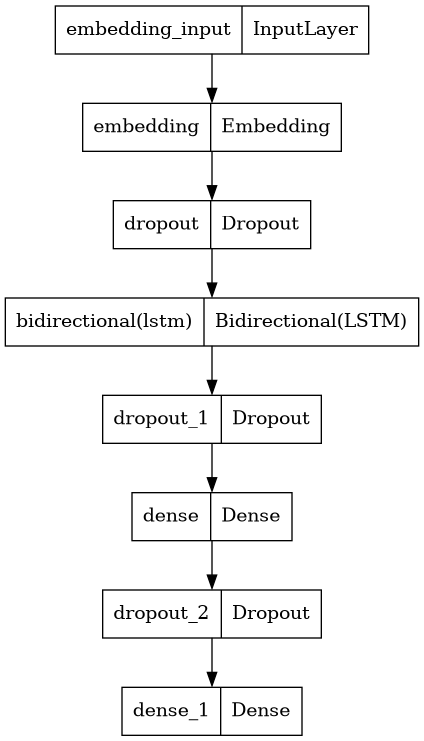

In [15]:
def get_model(summary=True):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        tf.keras.layers.Dropout(.4),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units)),
        tf.keras.layers.Dropout(.4),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(.4),
        tf.keras.layers.Dense(1)
    ])

    model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=tf.metrics.BinaryAccuracy())

    if summary:
        model.summary()
    return model
model=get_model()
plot_model(model)

In [31]:
epochs = 20
early_stopping = EarlyStopping(patience=6, restore_best_weights=True, verbose=True)
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=epochs,
    callbacks=[early_stopping])

Epoch 1/20
250/250 [==============================] - 4s 7ms/step - loss: 0.4066 - binary_accuracy: 0.7452 - val_loss: 0.0982 - val_binary_accuracy: 0.9647
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.0715 - binary_accuracy: 0.9751 - val_loss: 0.0887 - val_binary_accuracy: 0.9710
Epoch 3/20
250/250 [==============================] - 1s 5ms/step - loss: 0.0321 - binary_accuracy: 0.9895 - val_loss: 0.1246 - val_binary_accuracy: 0.9694
Epoch 4/20
250/250 [==============================] - 1s 5ms/step - loss: 0.0171 - binary_accuracy: 0.9950 - val_loss: 0.1004 - val_binary_accuracy: 0.9746
Epoch 5/20
250/250 [==============================] - 1s 6ms/step - loss: 0.0116 - binary_accuracy: 0.9965 - val_loss: 0.1055 - val_binary_accuracy: 0.9753
Epoch 6/20
250/250 [==============================] - 1s 5ms/step - loss: 0.0103 - binary_accuracy: 0.9968 - val_loss: 0.1237 - val_binary_accuracy: 0.9721
Epoch 7/20
250/250 [==============================] - 1s 6ms/ste

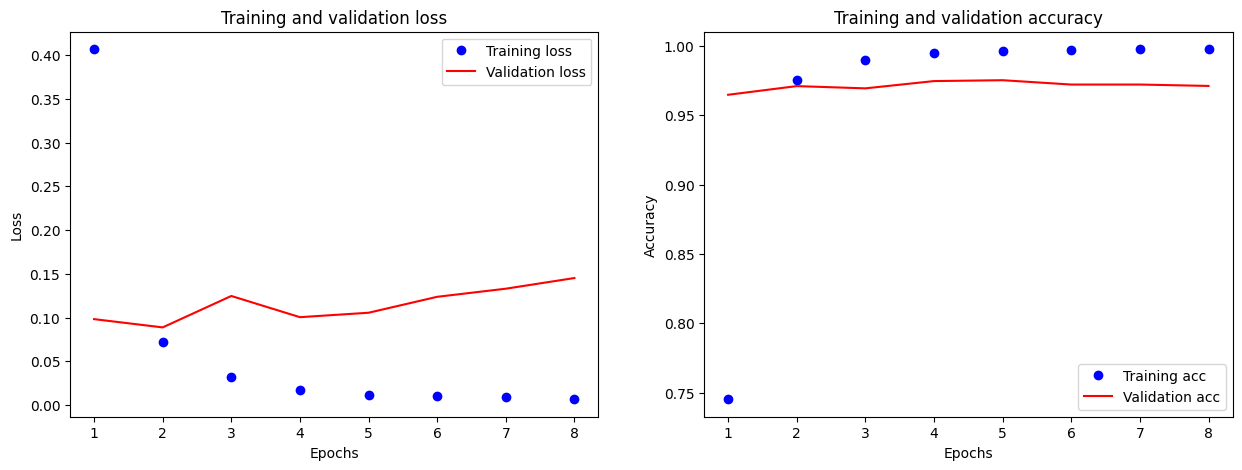

In [32]:
plot_history(history.history)

### Test Examples 

In [33]:
#new
example = '<sos> ' + "معاذ طه عوض" + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 457ms/step


array([[0.99881446]], dtype=float32)

In [34]:
#new
example = "باسم وحيد السيد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 36ms/step


array([[0.99566334]], dtype=float32)

In [35]:
#new
example = "شسي شسي شسي"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 34ms/step


array([[0.01532347]], dtype=float32)

In [36]:
#new
example = "باسمم وحةد السد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.01532347]], dtype=float32)

In [37]:
#new
example = "مريم محمد محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 30ms/step


array([[0.9897226]], dtype=float32)

In [38]:
#new
example = "محمد مريم محمد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 33ms/step


array([[0.98908]], dtype=float32)

In [39]:
#new
example = "مريم محمد على"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 33ms/step


array([[0.9896026]], dtype=float32)

In [40]:
#new
example = "محمد طه عوض"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.99614465]], dtype=float32)

In [41]:
#new
example = "زيادد عبدالرحمنت محد"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 32ms/step


array([[0.00113339]], dtype=float32)

In [43]:
#new
example = "دزيادد محمد سشيبسيب "
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 44ms/step


array([[0.12396854]], dtype=float32)

In [44]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = tokenize.texts_to_sequences([example])
tf.nn.sigmoid(model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 473ms/step


array([[0.9998585]], dtype=float32)

# Saving and loading the trained model 

In [46]:
model.save(f'models/{name}_lstm_32_dropout4_model.h5')

In [47]:
new_model = tf.keras.models.load_model(f'models/{name}_lstm_32_dropout4_model.h5')
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          482720    
                                                                 
 dropout_3 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

## Saving and loading the tokenizer

In [48]:
import pickle

# saving
with open(f'models/{name}_lstm_32_dropout4_model_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenize, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open(f'models/{name}_lstm_32_dropout4_model_tokenizer.pickle', 'rb') as handle:
    new_tokenizer = pickle.load(handle)

In [49]:
#new
example = "محمد طه عوض لاشين"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 471ms/step


array([[0.9998585]], dtype=float32)

In [50]:
#new
example = "دزيادد محم سشيبسيب "
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 461ms/step


array([[0.01532347]], dtype=float32)

In [51]:
#new
example = "زيادد عبدالرحمنت محمدد"
example = '<sos> ' + example + ' <eos>'
example_vect = new_tokenizer.texts_to_sequences([example])
tf.nn.sigmoid(new_model.predict(example_vect)).numpy()

1/1 [==============================] - 0s 31ms/step


array([[0.01532347]], dtype=float32)

30000 10000 30000 10000
Epoch 1/10
235/235 [==============================] - 4s 8ms/step - loss: 0.4244 - binary_accuracy: 0.7354 - val_loss: 0.1031 - val_binary_accuracy: 0.9640
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0707 - binary_accuracy: 0.9747 - val_loss: 0.1095 - val_binary_accuracy: 0.9691
Epoch 3/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0331 - binary_accuracy: 0.9890 - val_loss: 0.1061 - val_binary_accuracy: 0.9721
Epoch 4/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0220 - binary_accuracy: 0.9936 - val_loss: 0.1331 - val_binary_accuracy: 0.9683
Epoch 5/10
235/235 [==============================] - 2s 6ms/step - loss: 0.0132 - binary_accuracy: 0.9960 - val_loss: 0.1370 - val_binary_accuracy: 0.9688
Epoch 5: early stopping
30000 10000 30000 10000
Epoch 1/10
235/235 [==============================] - 4s 9ms/step - loss: 0.4245 - binary_accuracy: 0.7308 - val_loss: 0.1080 - val_binary_accuracy:

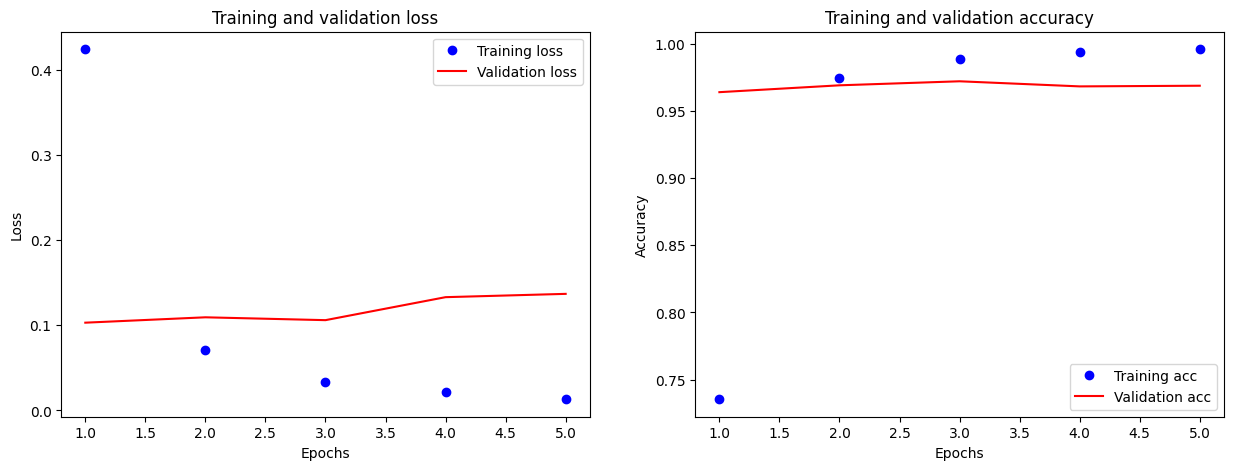

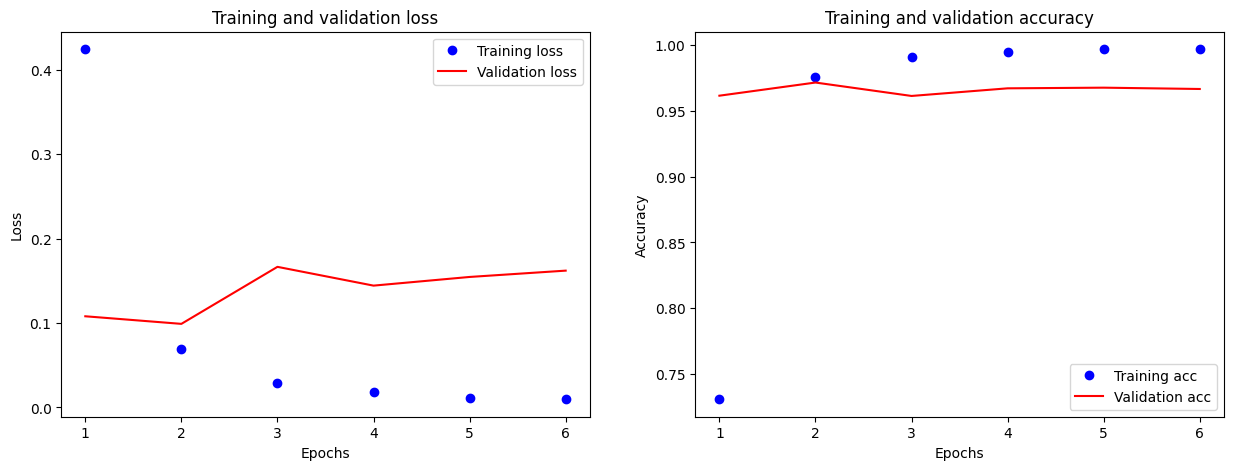

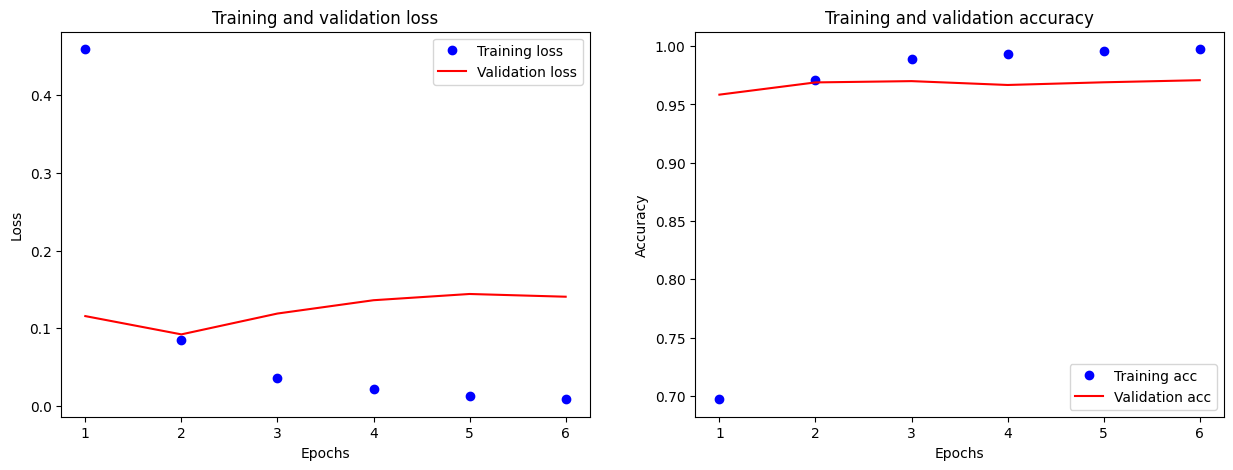

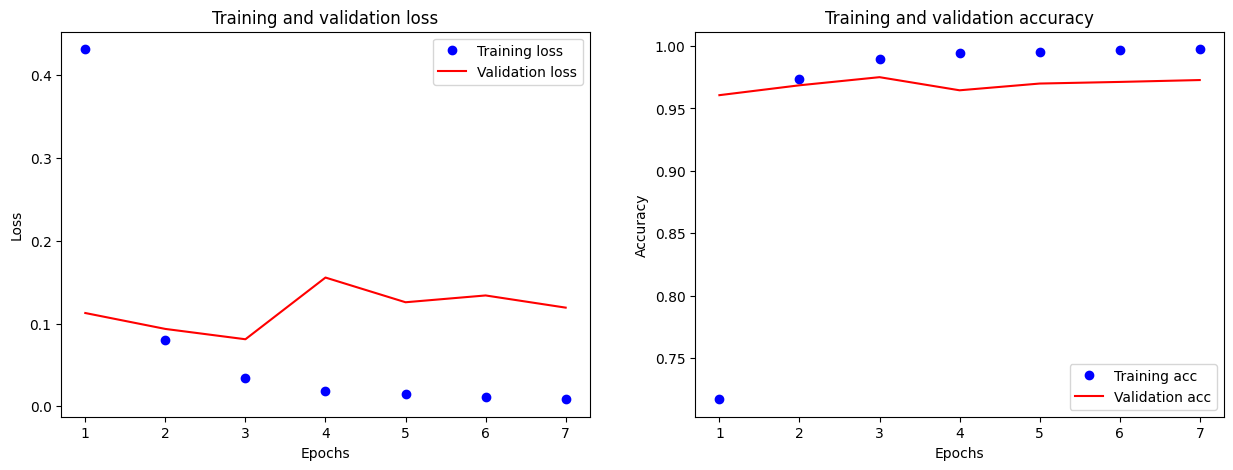

In [52]:
from sklearn.model_selection import KFold

early_stopping = EarlyStopping(patience=4, restore_best_weights=True, verbose=True)
epochs = 10

kfold = KFold(n_splits=4)

for train, valid in kfold.split(X):
    x_train, y_train = X[train], df['class'].values[train]
    x_valid, y_valid = X[valid], df['class'].values[valid]
    print(len(x_train), len(x_valid), len(y_train), len(y_valid))
    
    ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(128)
    ds_valid = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(128)
    
    model = get_model(False)
    history = model.fit(
        ds_train,
        validation_data=ds_valid,
        epochs=epochs,
        callbacks=[early_stopping])
    plot_history(history.history)